In [1]:
# Reading in data and verify it is the same set as the book
OfflinePath = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/offline.final.trace.txt'
# OfflinePath = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/offline_data.txt"

onlinePath = 'C:/Users/casey/Dropbox/SMU_DataScience/MSDS_7333_QuantifyingTheWorld/Homework/CaseStudy1/online.final.trace.txt'
# onlinePath =  '/home/kyle/Documents/thomaskh522@gmail.com/SMU/Quant the World/RTLS_CaseStudy/Data/online_data.txt'


readData = 
  function(filename, 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    

    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    offline$posX = round(offline$posX,0)
    offline$posY = round(offline$posY,0)
      
    offline$posXY = paste(offline$posX, offline$posY, sep = "-")
      
    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

processLine = function(x){
    tokens = strsplit(x, "[;=,]")[[1]]
    
    if (length(tokens) == 10)
        return(NULL)
    tmp = matrix(tokens[-(1:10)], ncol=4, byrow = TRUE)
    cbind(matrix(tokens[c(2,4,6:8,10)], nrow = nrow(tmp), ncol=6, byrow=TRUE), tmp)
}

roundOrientation = function(angles) {
    refs = seq(0, by = 45, length = 9)
    q = sapply(angles, function(o) which.min(abs(o-refs)))
    c(refs[1:8], 0)[q]
}
     
offline = readData(OfflinePath)
# online = readData(OnlinePath1)

null device 
          1

null device 
          1

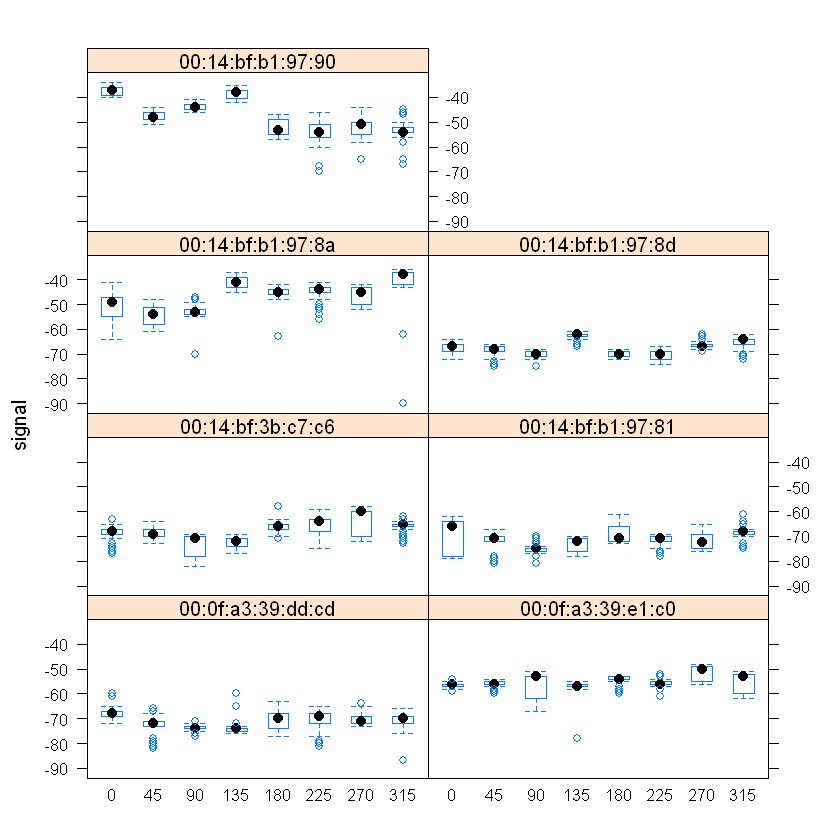

In [2]:
#pdf(file = "Geo_BoxplotSignalByMacAngle.pdf", width = 7)
oldPar = par(mar = c(3.1, 3, 1, 1))

library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12, 
       layout = c(2,4))

par(oldPar)
dev.off()

# summary(offline$signal)

#pdf(file = "Geo_DensitySignalByMacAngle.pdf", width = 8, height = 12)
oldPar = par(mar = c(3.1, 3, 1, 1))

densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

par(oldPar)
dev.off()

null device 
          1

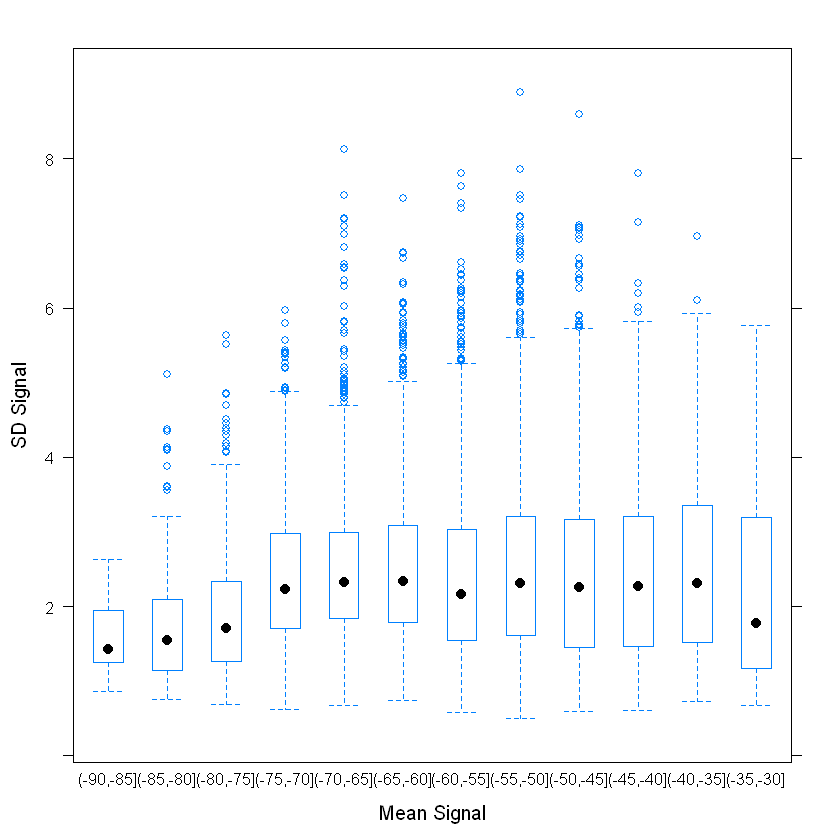

In [3]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

offlineSummary = do.call("rbind", signalSummary)  

#pdf(file = "Geo_BoxplotSignalSDByAvg.pdf", width = 10)
oldPar = par(mar = c(3.1, 3, 1, 1))

breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary,
       xlab = "Mean Signal", ylab = "SD Signal")

par(oldPar)
dev.off()

null device 
          1

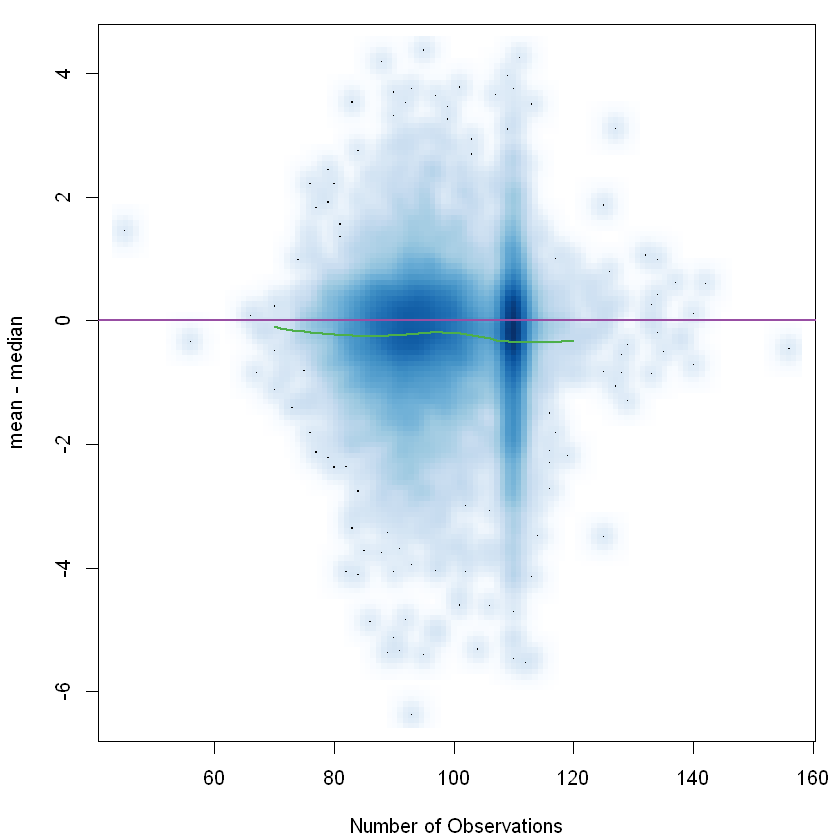

In [4]:
#pdf(file = "Geo_ScatterMean-Median.pdf", width = 10)
oldPar = par(mar = c(4.1, 4.1, 1, 1))
submac = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

par(oldPar)
dev.off()

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


[1] "00:0f:a3:39:e1:c0"
[1] "00:0f:a3:39:dd:cd"


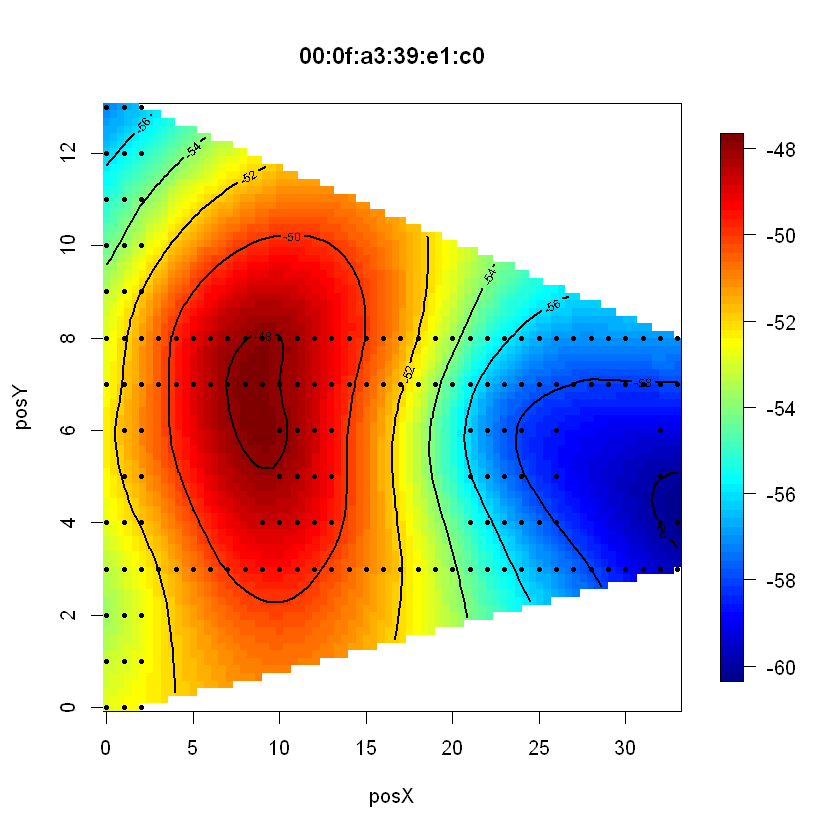

[1] "00:14:bf:b1:97:8a"


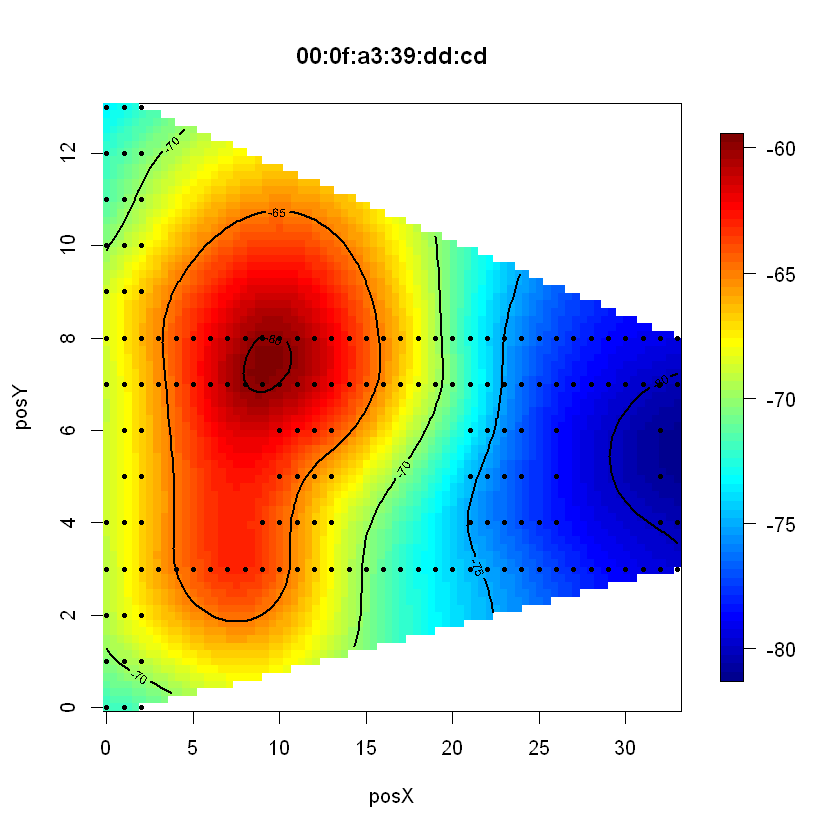

[1] "00:14:bf:3b:c7:c6"


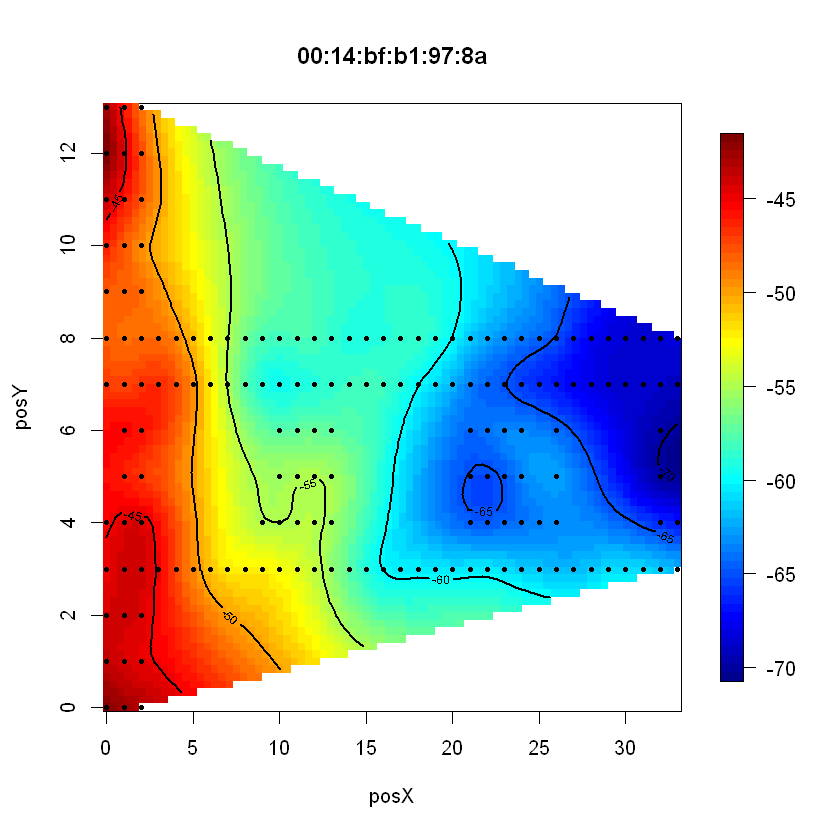

[1] "00:14:bf:b1:97:90"


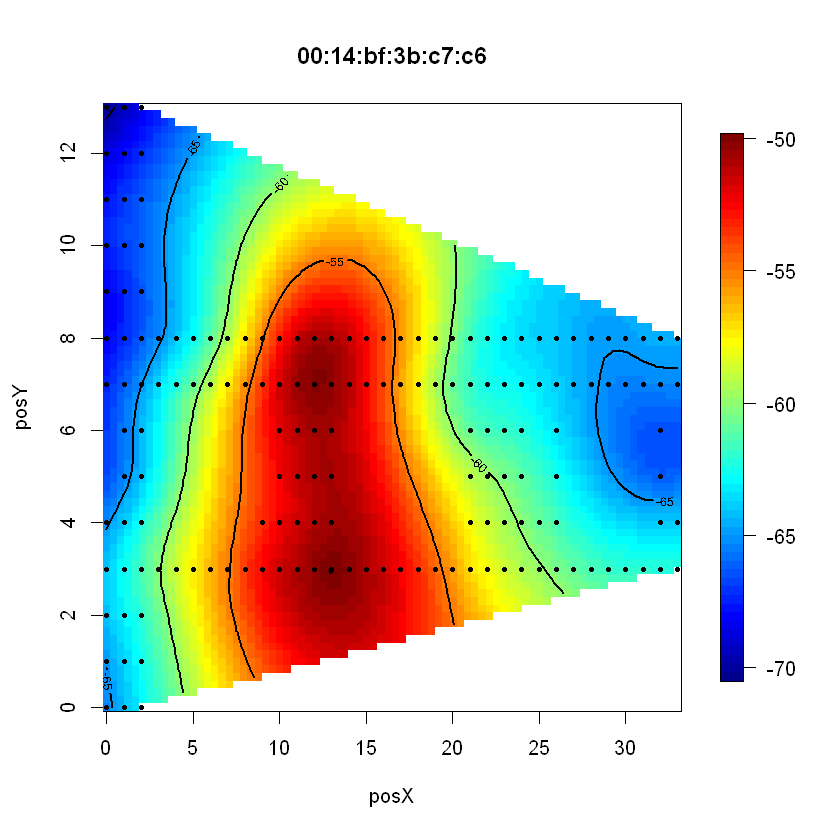

[1] "00:14:bf:b1:97:8d"


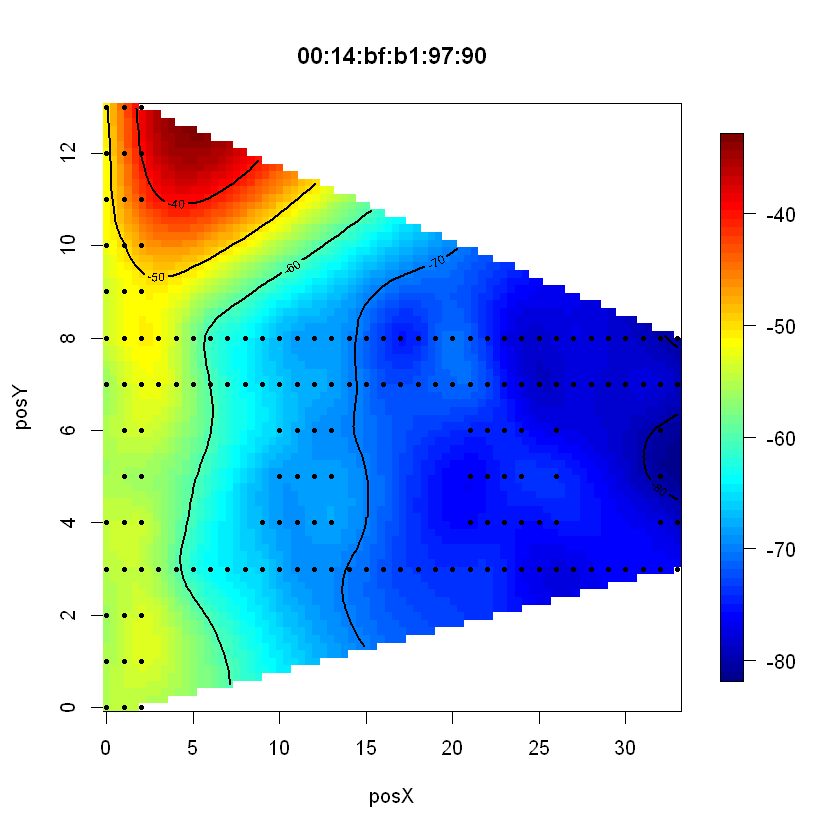

[1] "00:14:bf:b1:97:81"


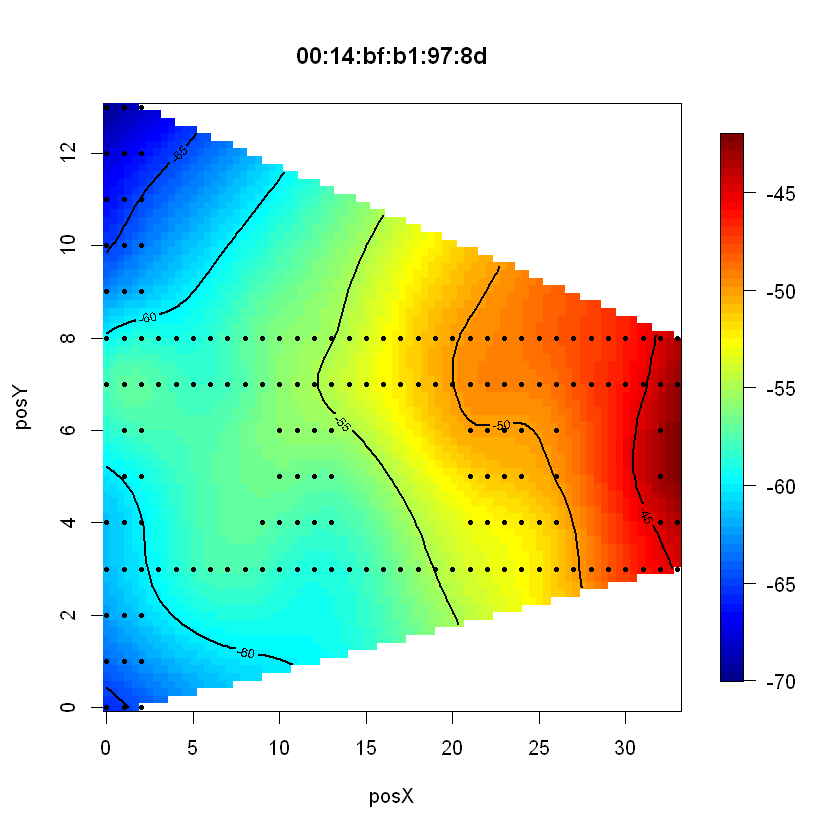

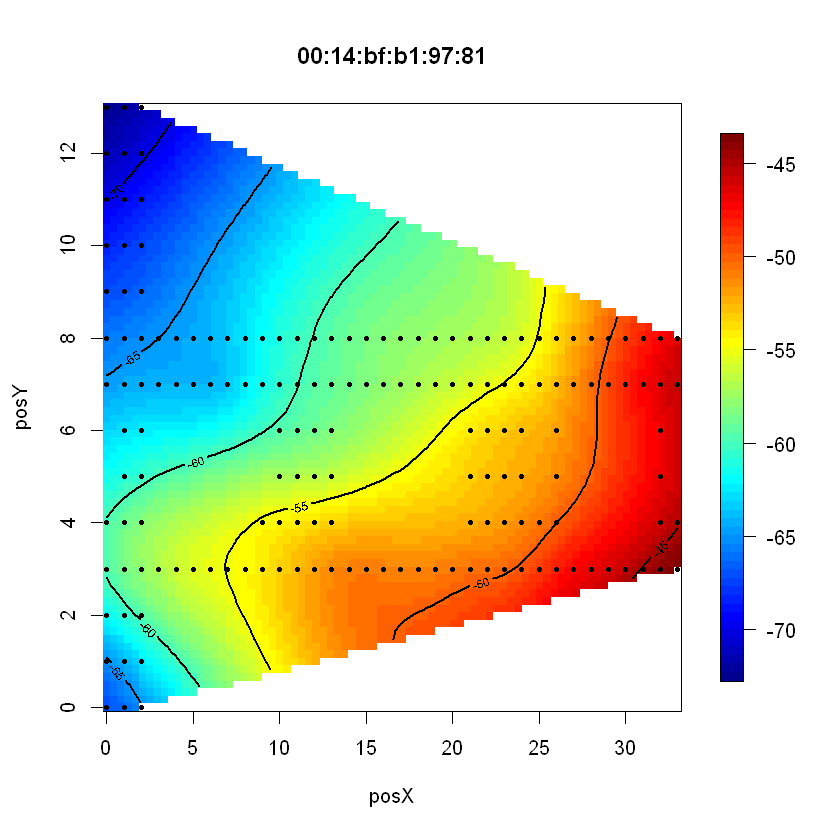

In [5]:
library(fields)
plotAllHeatMaps = function(){
    for (thismac in submac){
        print(thismac)

        oneAPAngle = subset(offlineSummary, mac == thismac & angle == 0)

        smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                   oneAPAngle$avgSignal)

        vizSmooth = predictSurface(smoothSS)

        plot.surface(vizSmooth, type = "C")

        points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

        title(thismac)

    }
    
    
}

plotAllHeatMaps()


[1] "00:0f:a3:39:e1:c0"
[1] "00:0f:a3:39:dd:cd"


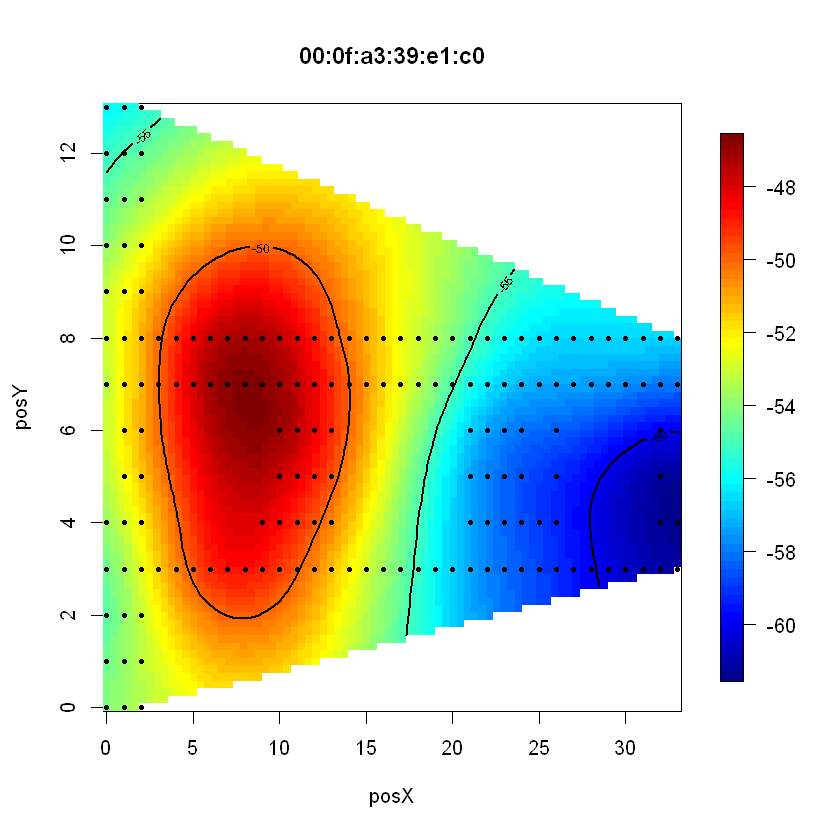

[1] "00:14:bf:b1:97:8a"


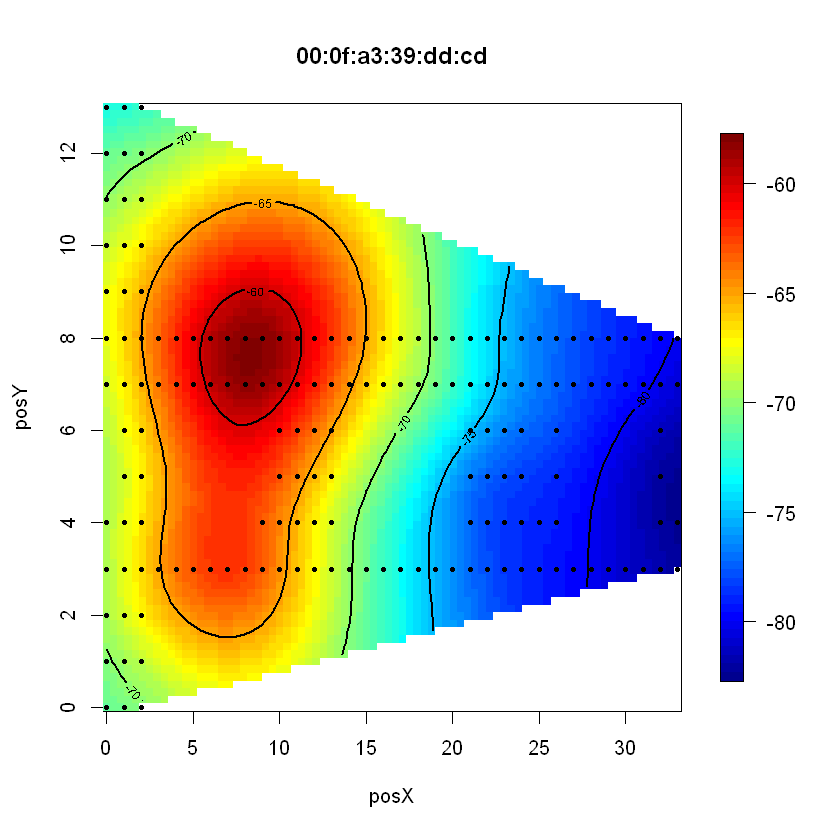

[1] "00:14:bf:3b:c7:c6"


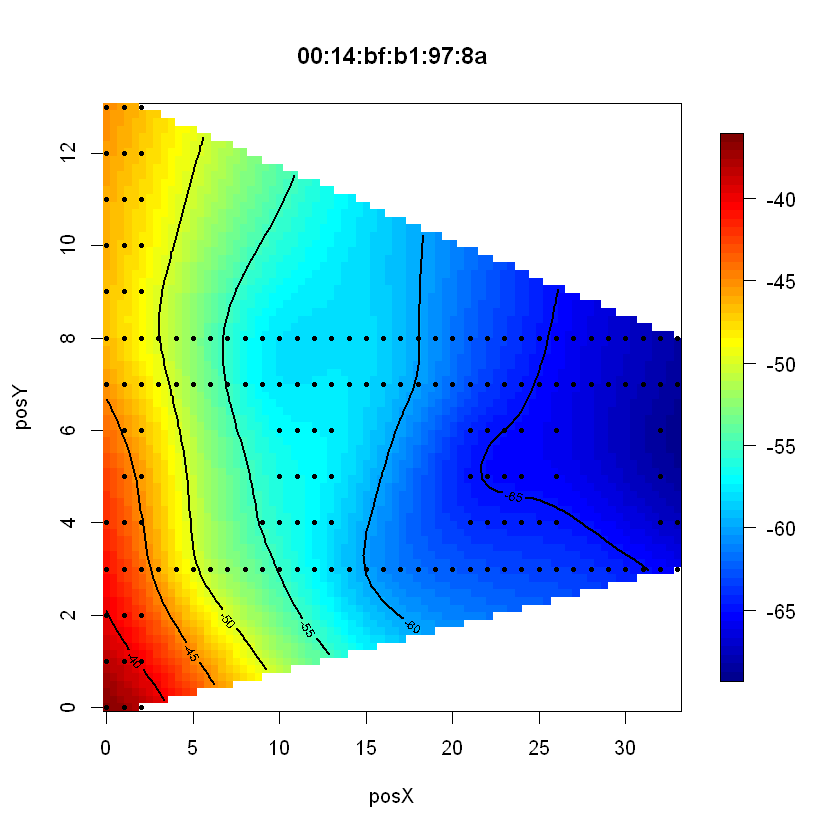

[1] "00:14:bf:b1:97:90"


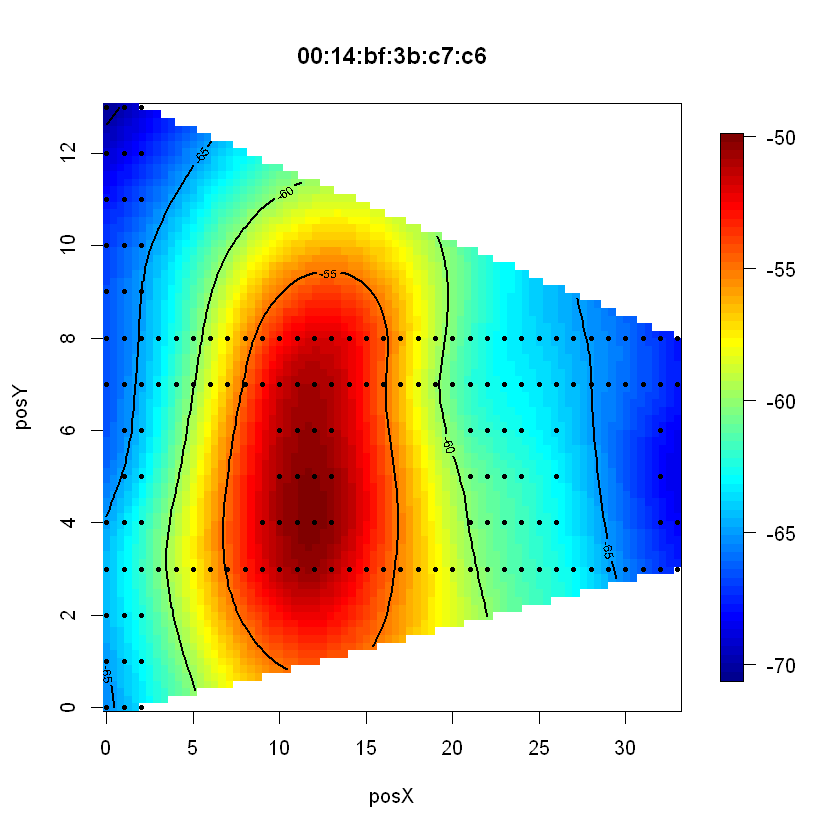

[1] "00:14:bf:b1:97:8d"


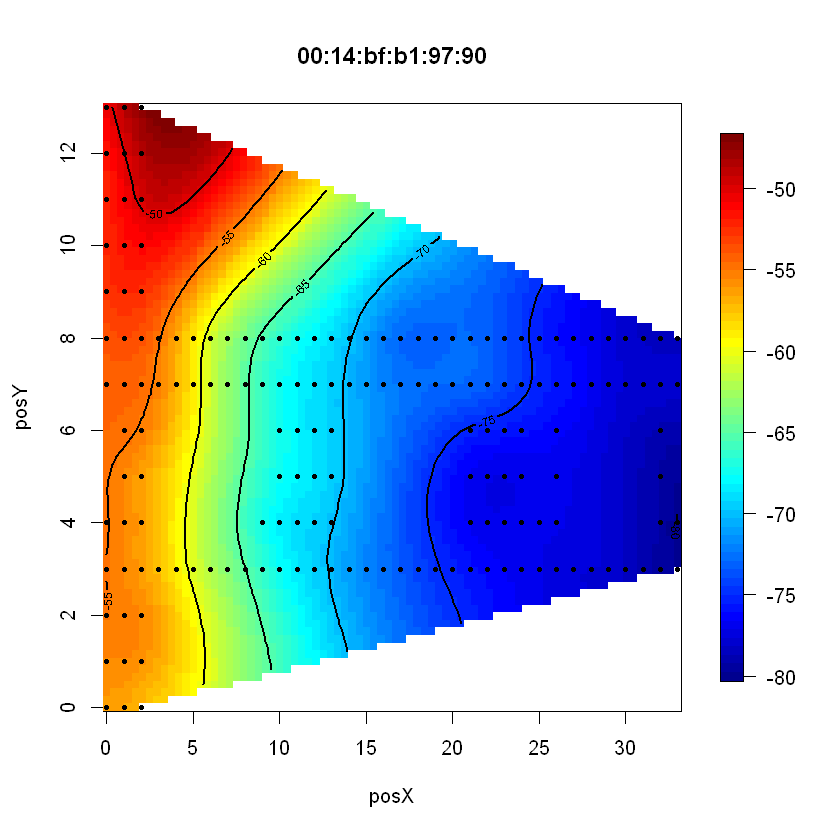

[1] "00:14:bf:b1:97:81"


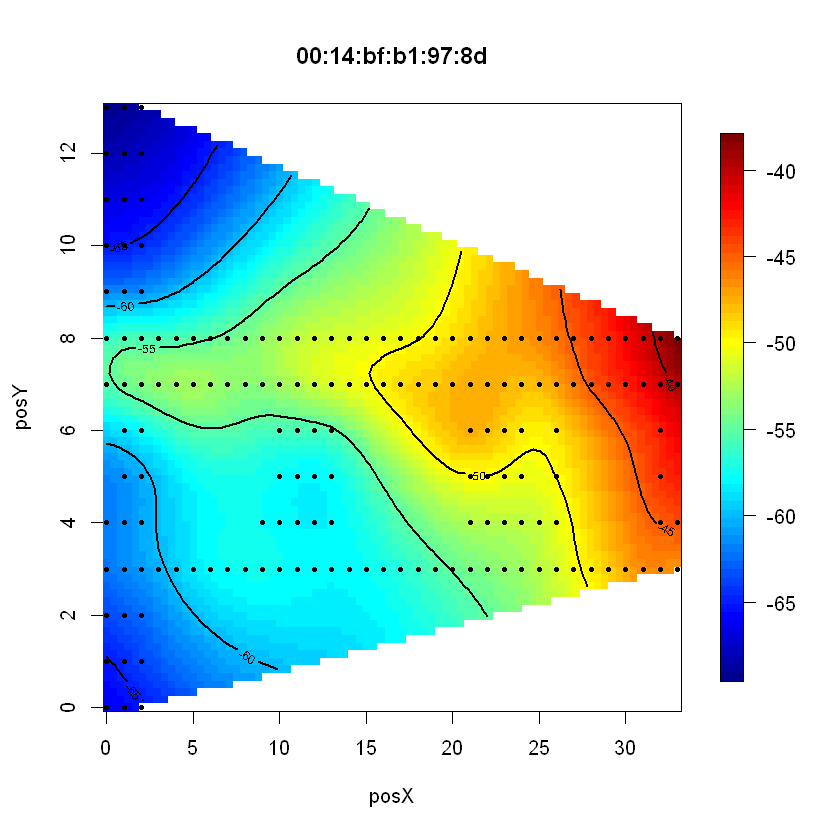

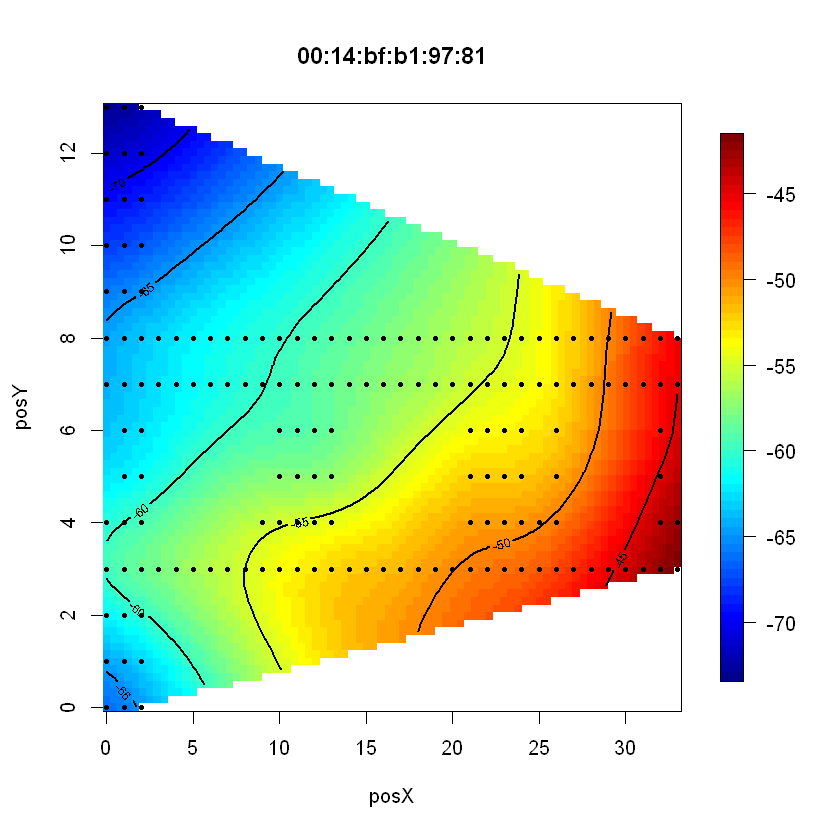

In [6]:
# removed the angle from subset. This will combine all the angles

plotAllHeatMaps = function(){
    for (thismac in submac){
        print(thismac)

        oneAPAngle = subset(offlineSummary, mac == thismac)

        smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                   oneAPAngle$avgSignal)

        vizSmooth = predictSurface(smoothSS)

        plot.surface(vizSmooth, type = "C")

        points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

        title(thismac)

    }
    
    
}

plotAllHeatMaps()


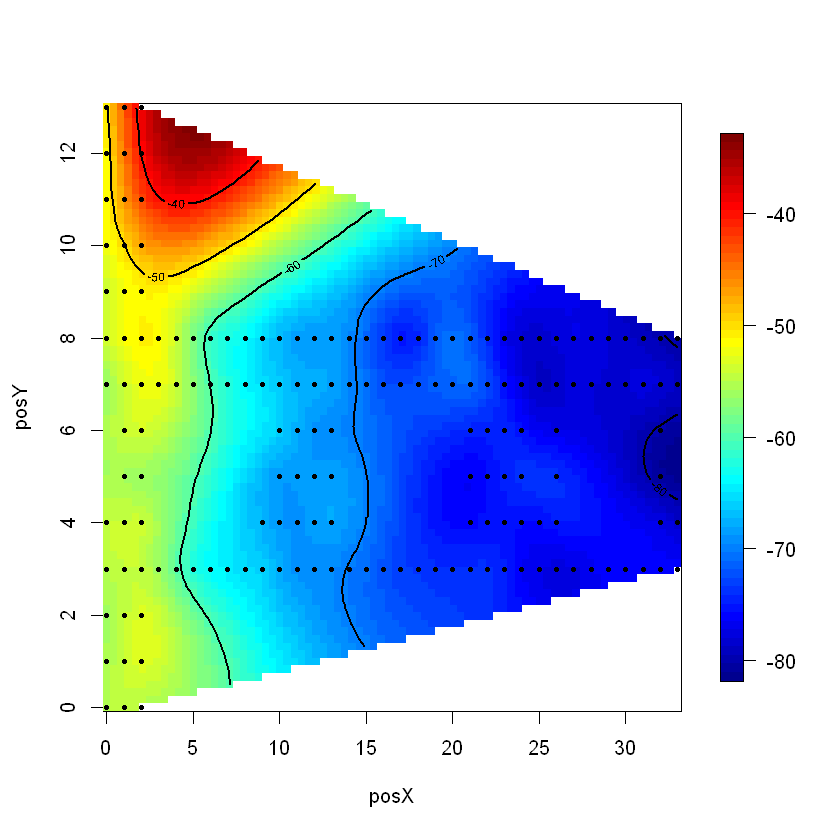

In [7]:
library(fields)

oneAPAngle = subset(offlineSummary, mac == submac[5] & angle == 0)

smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

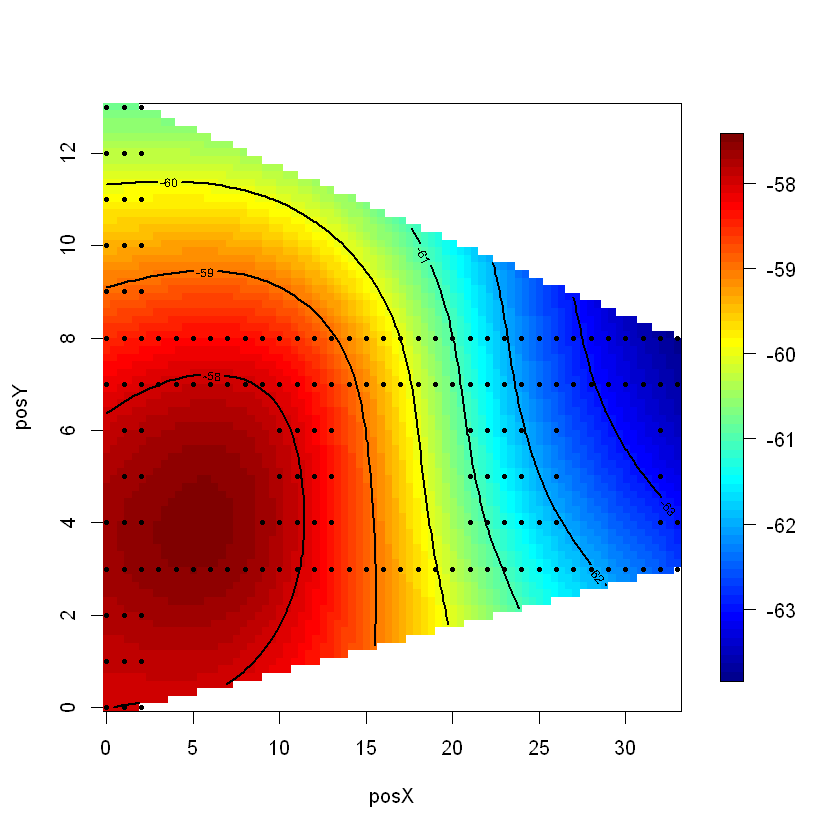

In [8]:
# overall signal strength
library(fields)

allAPAngle = subset(offlineSummary, angle == 0)

smoothSS = Tps(allAPAngle[, c("posX","posY")], 
               allAPAngle$avgSignal)

vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")

points(allAPAngle$posX, allAPAngle$posY, pch=19, cex = 0.5)



In [9]:
unique(offlineSummary$mac)

[1] "00:0f:a3:39:dd:cd" "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d"
[7] "00:14:bf:b1:97:90"

In [10]:
macc0 = submac[1]
maccd = submac[2]

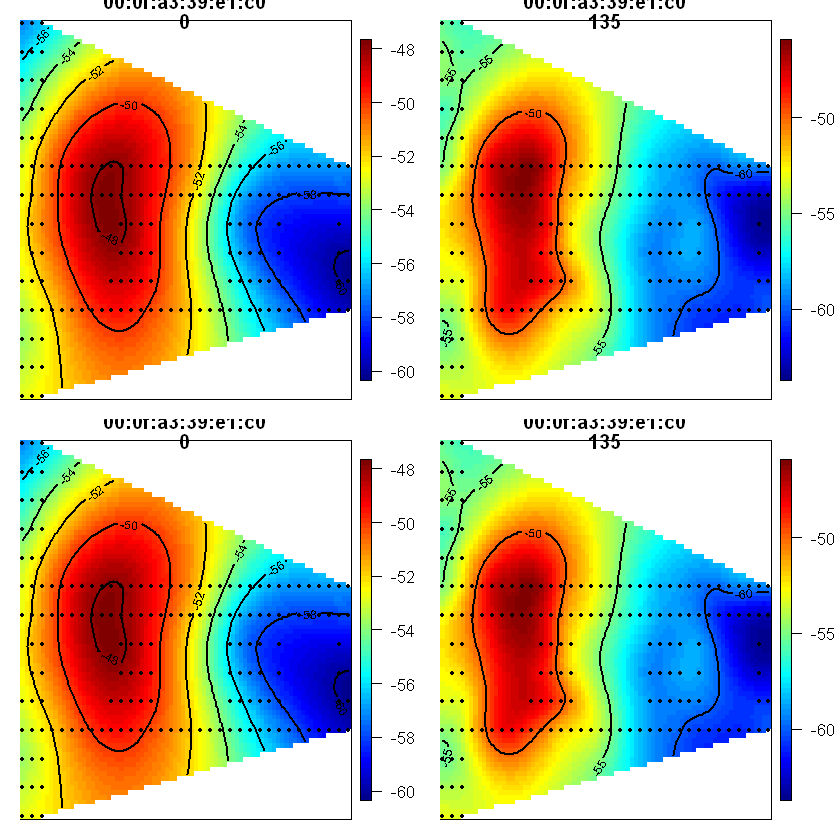

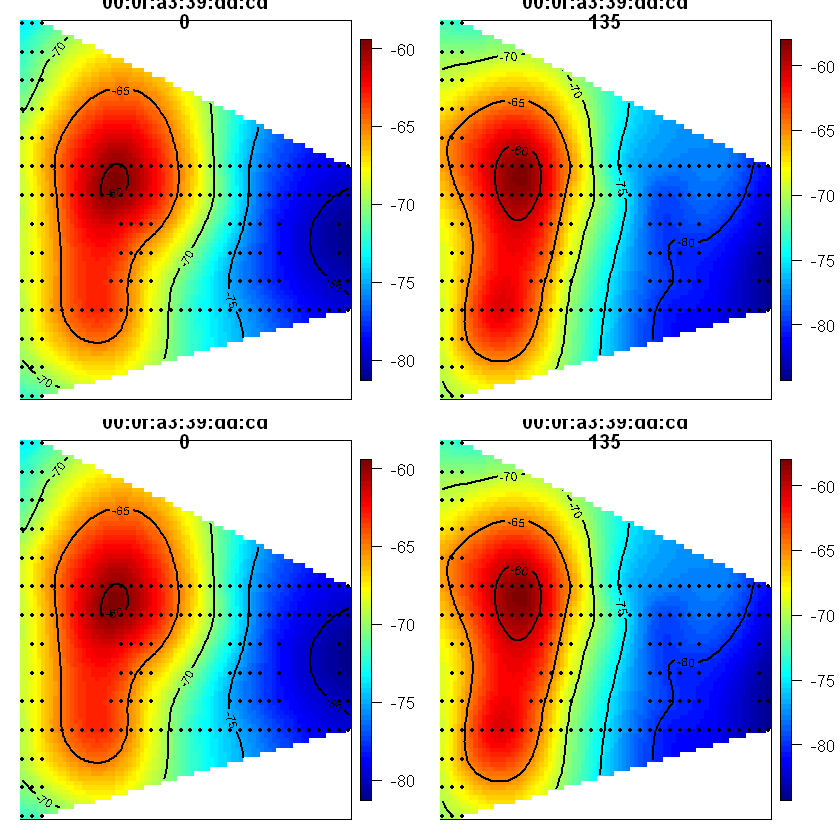

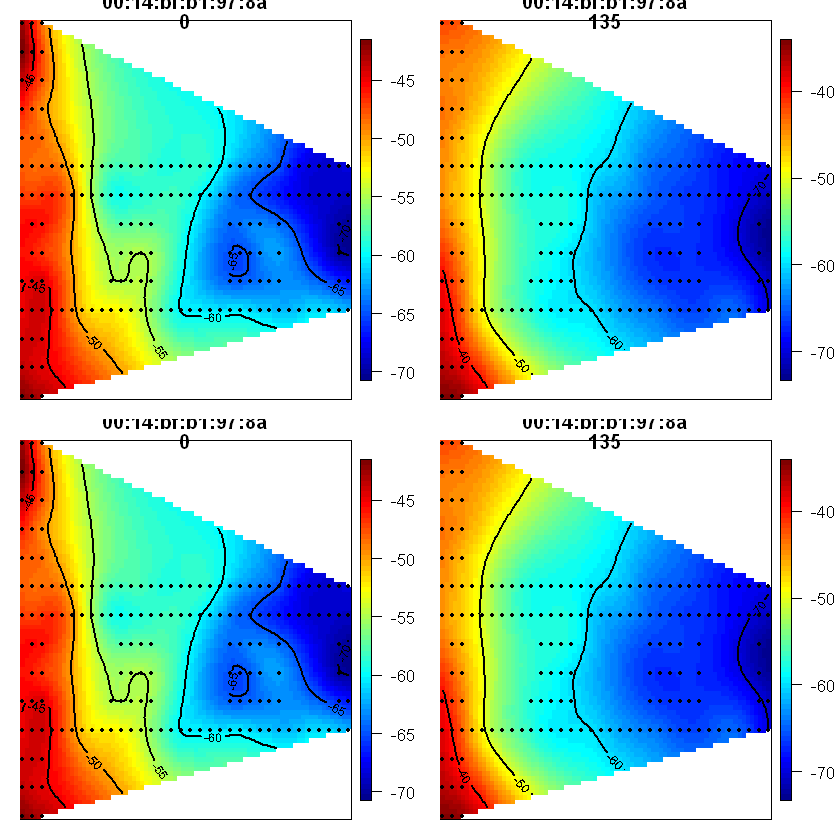

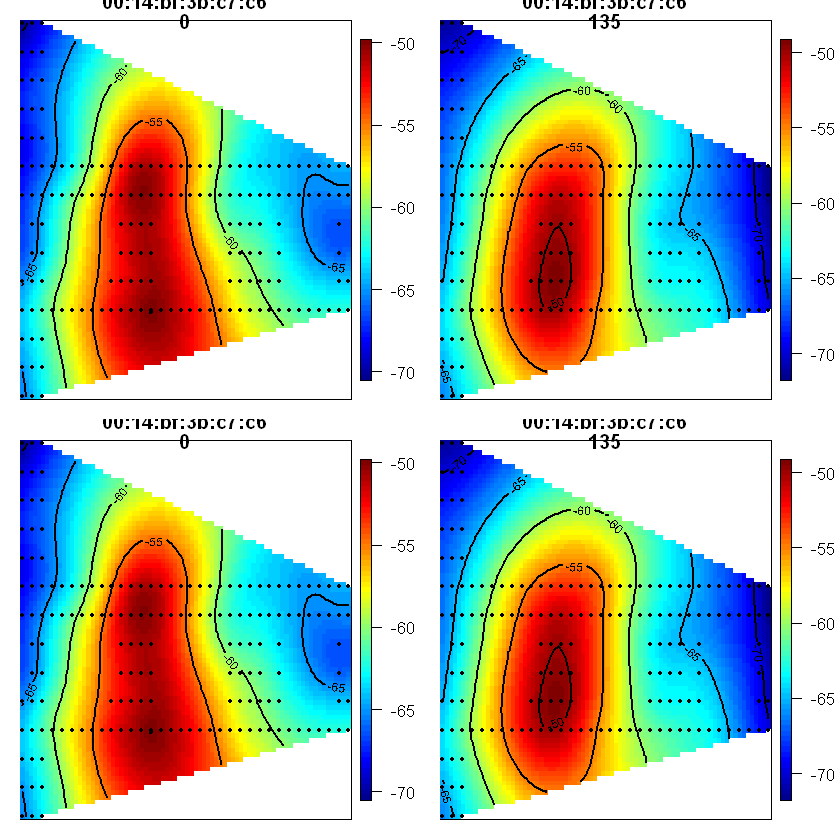

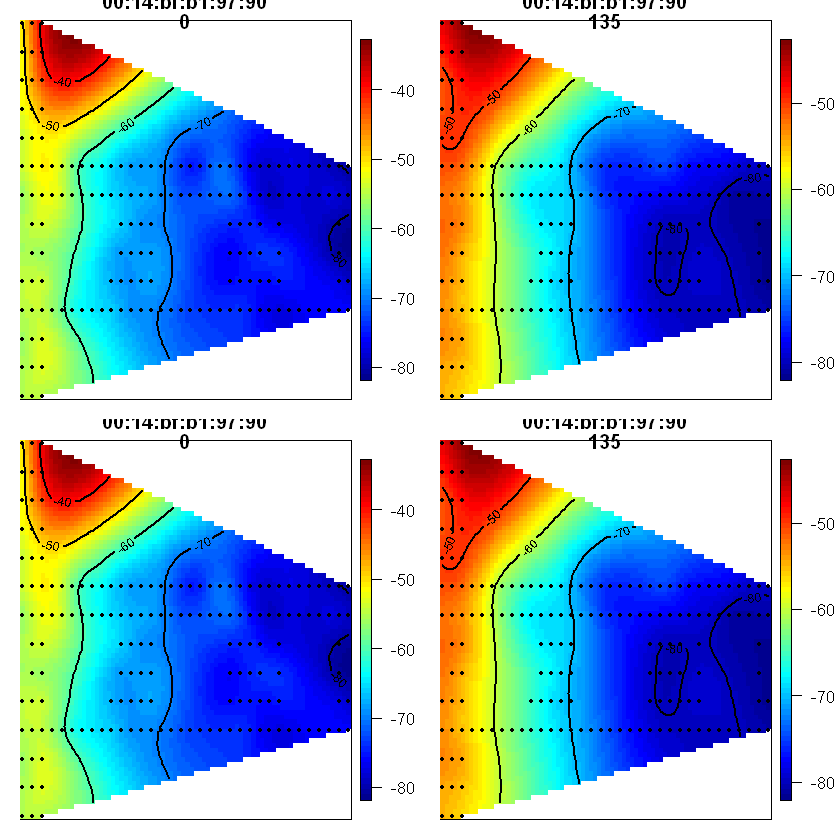

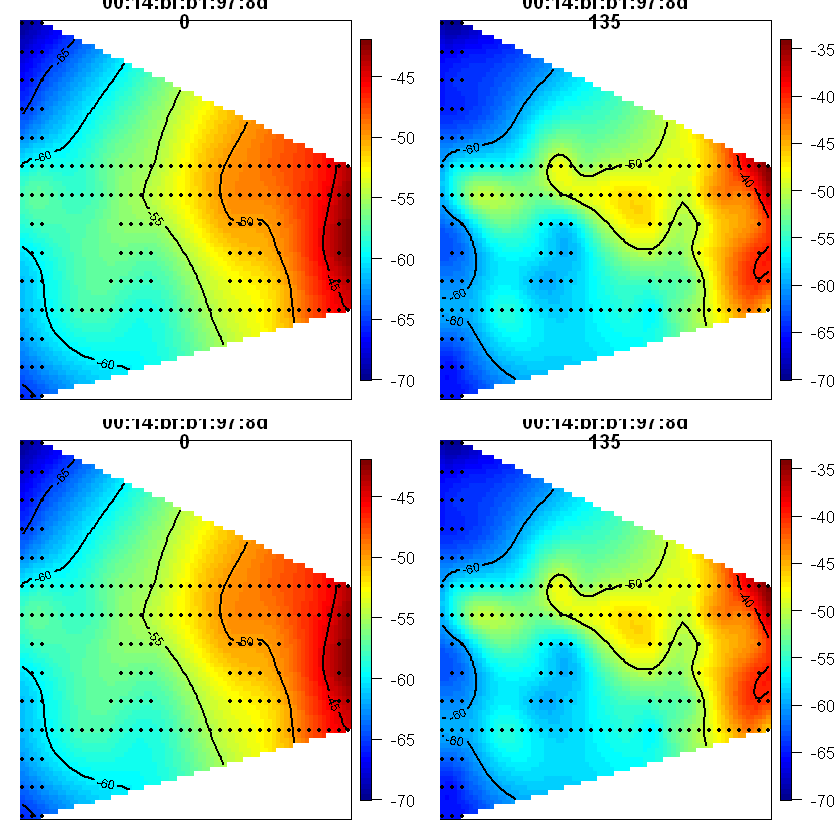

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:b1:97:8a`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:3b:c7:c6`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:8d`
NULL

$`00:14:bf:b1:97:81`
NULL

$`00:14:bf:b1:97:81`
NULL

$`00:14:bf:b1:97:81`
NULL

$`00:14:bf:b1:97:81`
NULL

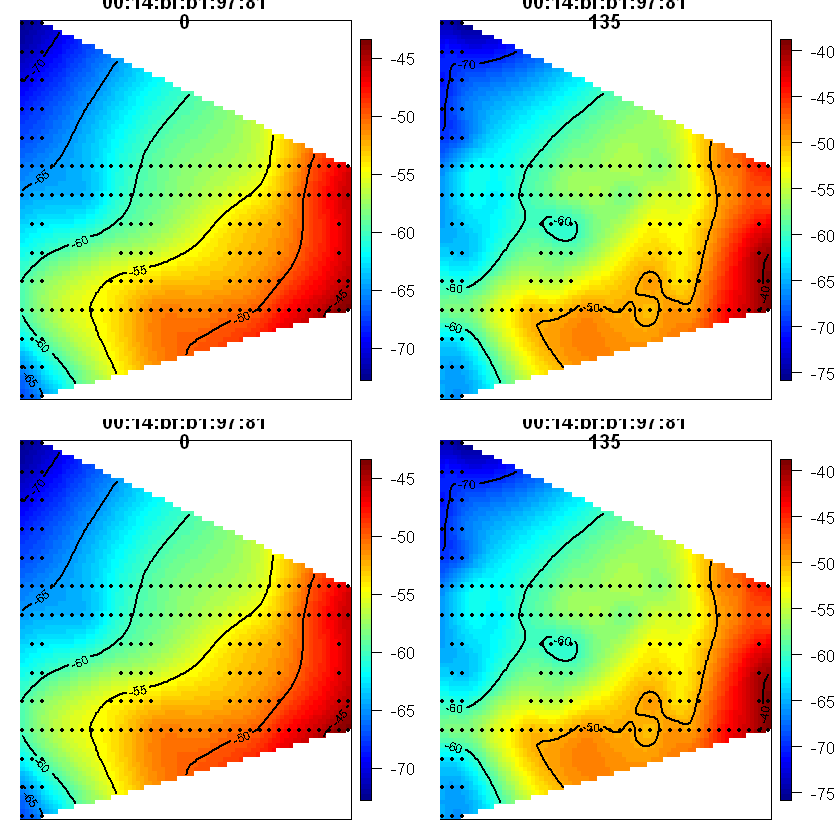

In [11]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
  title(paste(c(mac, angle), sep = " "))
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = submac[ rep(c(1,2,3,4,5,6,7), each = 4) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
# par(parCur)

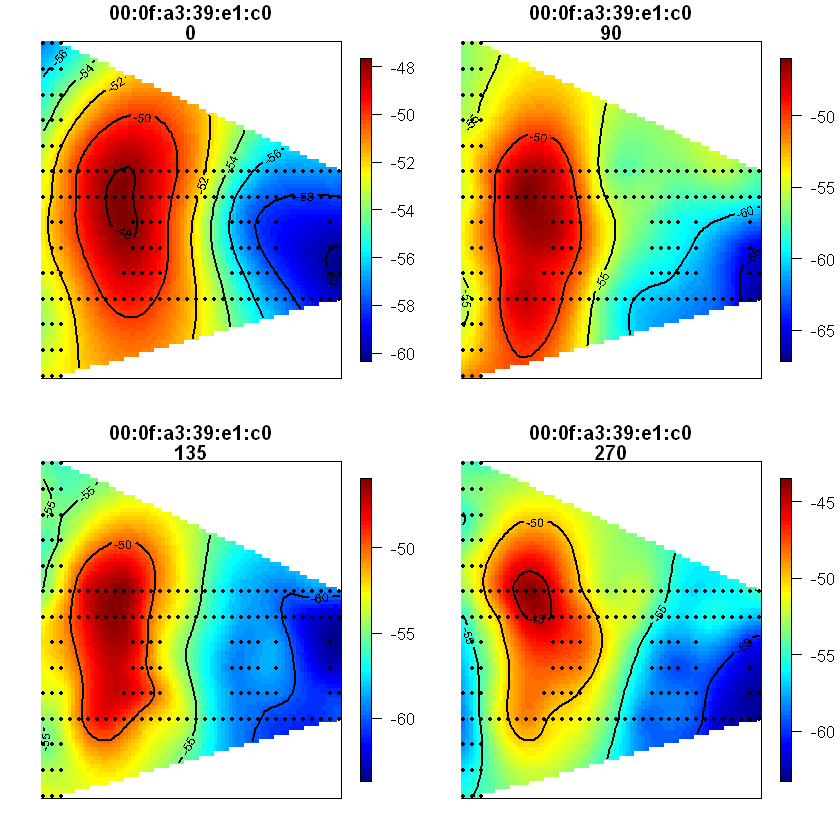

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

$`00:0f:a3:39:dd:cd`
NULL

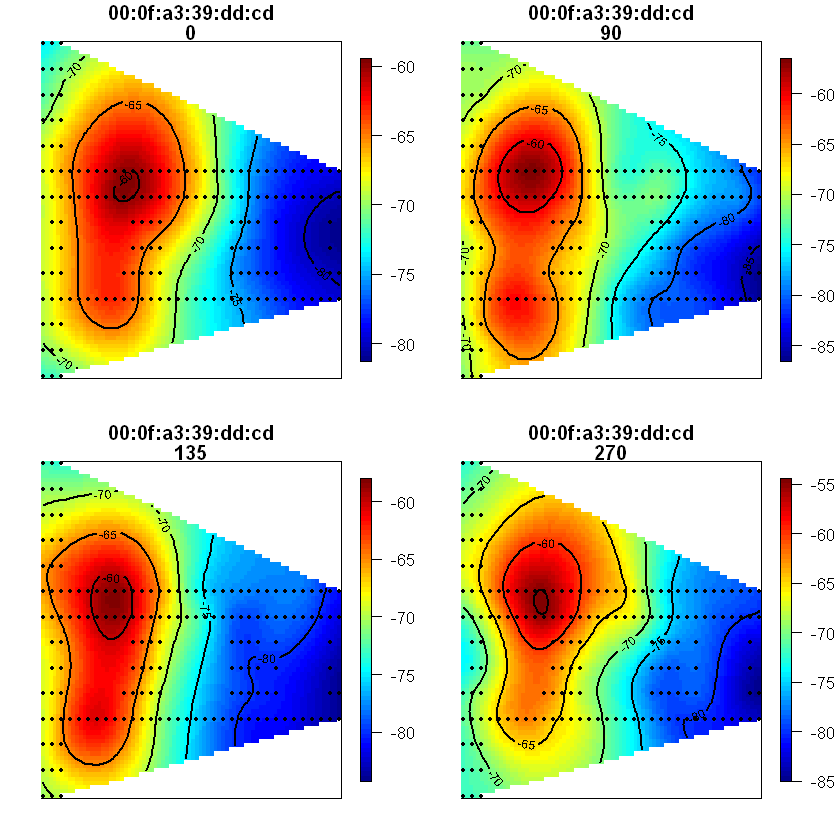

In [12]:
# plots for all angles of 00:0f:a3:39:e1:c0
parCur = par(mfrow = c(2,2), mar = rep(2, 4))

mapply(surfaceSS, mac = submac[ rep(c(1,2), each = 4) ], 
       angle = rep(c(0, 90, 135, 270), 2),
       data = list(data = offlineSummary))

In [13]:
# install.packages('dplyr')
library(dplyr)
RSSmax = offlineSummary %>%
select(mac, posX, posY,avgSignal) %>%
group_by(mac,posX,posY) %>%
# summarise(max(avgSignal), mean(posX), mean(posY))
summarise(max=max(avgSignal))

macLocations = RSSmax %>%
group_by(mac) %>%
arrange(max)

macLocations


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



mac,posX,posY,max
00:0f:a3:39:dd:cd,32,6,-80.82353
00:0f:a3:39:dd:cd,32,5,-80.44167
00:0f:a3:39:dd:cd,33,4,-79.29245
00:0f:a3:39:dd:cd,33,3,-79.04545
00:0f:a3:39:dd:cd,31,3,-79.01802
00:0f:a3:39:dd:cd,32,7,-78.97248
00:0f:a3:39:dd:cd,30,3,-78.46789
00:0f:a3:39:dd:cd,32,4,-78.33636
00:14:bf:b1:97:90,32,6,-78.25926
00:14:bf:b1:97:90,31,3,-78.16854


In [14]:
submac[-2]

[1] "00:0f:a3:39:e1:c0" "00:14:bf:b1:97:8a" "00:14:bf:3b:c7:c6"
[4] "00:14:bf:b1:97:90" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:81"

In [108]:
offlineSummary = subset(offlineSummary, mac != submac[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(submac[ -2 ], c("x", "y") ))

AP

# added the location of the missing mac

# AP = matrix( c( 7.5, 6.3, 32,6, 2.5, -.8, 12.8, -2.8,  
#                 1, 14, 33.5, 9.3,  33.5, 2.8),
#             ncol = 2, byrow = TRUE,
#             dimnames = list(submac, c("x", "y") ))

# AP

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


ERROR while rich displaying an object: Error in if (is.character(x) && nchar(x) == 0) NA_character_ else as.name(x): missing value where TRUE/FALSE needed

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. re

$`00:0f:a3:39:e1:c0`
NULL

$<NA>
NULL

$<NA>
NULL

$<NA>
NULL

$<NA>
NULL

$<NA>
NULL

$<NA>
NULL

$<NA>
NULL


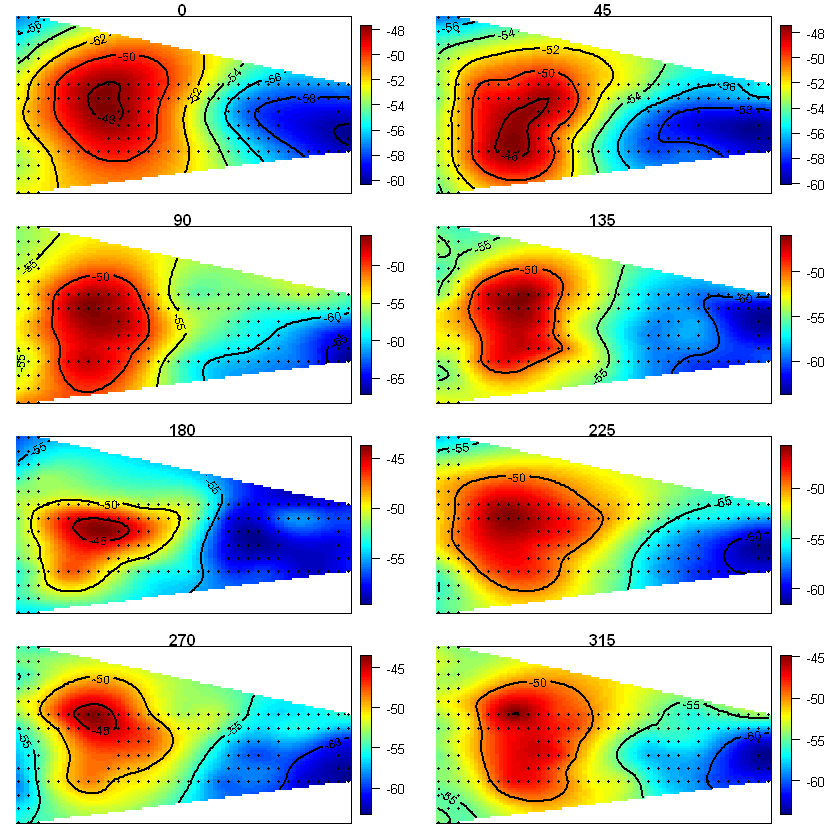

In [83]:
# Plot same mac for all angles

surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)
  title(angle)
}

parCur = par(mfrow = c(4,2), mar = rep(1,1, 4))

mapply(surfaceSS, mac = submac[1], 
       angle = c(0,45,90,135,180,225,270,315),
       data = list(data = offlineSummary))
 

### Plot Signal Strength vs. Distance to Access Point

In [17]:
# diffs = offlineSummary[ , c("posX", "posY")] - AP[ offlineSummary$mac, ]

# offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

# xyplot(signal ~ dist | factor(mac) + factor(angle), 
#        data = offlineSummary, pch = 19, cex = 0.3,
#        xlab ="distance")

# #pdf(file="Geo_ScatterSignalDist.pdf", width = 7, height = 10)
# oldPar = par(mar = c(3.1, 3.1, 1, 1))
# library(lattice)
# xyplot(signal ~ dist | factor(mac) + factor(angle), 
#        data = offlineSummary, pch = 19, cex = 0.3,
#        xlab ="distance")
# par(oldPar)
# dev.off()

# macs = unique(offlineSummary$mac)

### Bring in online test data

In [111]:
online = readData(onlinePath, subMacs = submac[-2])

# length(unique(online$posXY))

# tabonlineXYA = table(online$posXY, online$angle)
# tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

head(onlineSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,130.5,135,-52.22727,-62.94898,-61.81395,-40.06897,-63.04301,-55.23333
0-11,0-11,0,11,230.1,225,-51.70909,-70.08247,-70.09890,-54.08824,-69.13158,-53.88660
0-8,0-8,0,8,5.8,0,-49.50000,-64.25806,-72.59770,-45.65289,-60.79747,-49.58000
0-9,0-9,0,9,112.3,90,-55.27523,-73.96190,-72.70103,-47.81308,-69.45455,-46.88000
1-11,1-11,1,11,348.3,0,-53.26364,-66.96000,-66.80952,-48.41379,-65.00000,-54.84694
1-12,1-12,1,12,158.3,180,-56.39545,-69.82857,-69.15429,-48.16814,-68.69101,-49.59804


In [112]:
# dim(onlineSummary)
# names(onlineSummary)

m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)
  
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

angles

[1] 180 225 270

In [113]:
offlineSubset = offlineSummary[ offlineSummary$angle %in% angles, ]
head(offlineSubset)

,time,posX,posY,orientation,mac,signal,posXY,rawTime,angle,medSignal,avgSignal,num,sdSignal,iqrSignal
4136,2006-02-11 01:37:36,0,0,180.3,00:0f:a3:39:e1:c0,-87,0-0,1.139643e+12,180,-53,-55.02727,110,6.241999,2.00
28624,2006-02-11 02:07:32,0,1,180.1,00:0f:a3:39:e1:c0,-46,0-1,1.139645e+12,180,-47,-50.14545,110,5.844838,10.00
225432,2006-02-11 05:49:15,0,10,179.4,00:0f:a3:39:e1:c0,-57,0-10,1.139659e+12,180,-54,-54.72727,110,3.073739,5.00
232691,2006-02-11 05:57:34,0,11,180.4,00:0f:a3:39:e1:c0,-65,0-11,1.139659e+12,180,-57,-57.28440,109,3.040138,4.00
240031,2006-02-11 06:08:11,0,12,180.5,00:0f:a3:39:e1:c0,-55,0-12,1.139660e+12,180,-57,-57.70909,110,3.280035,3.00
247083,2006-02-11 06:20:19,0,13,180.3,00:0f:a3:39:e1:c0,-55,0-13,1.139660e+12,180,-53,-55.68182,110,3.845483,7.75


### Aggregate the signal strength

In [115]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")
head(trainSS)

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-54.76364,-67.04734,-64.83387,-36.20531,-65.50758,-56.18092
0-1,0-1,0,1,-52.23837,-64.67562,-65.33454,-38.19663,-67.03553,-57.05728
0-10,0-10,0,10,-54.45296,-63.59127,-67.66686,-44.92872,-66.24131,-53.34497
0-11,0-11,0,11,-55.39455,-65.34775,-65.62659,-48.63909,-66.73790,-55.01101
0-12,0-12,0,12,-55.10909,-67.04762,-69.84874,-43.76612,-70.96543,-53.61035
0-13,0-13,0,13,-54.29091,-70.53715,-71.86505,-47.12531,-69.69705,-57.19858


### Find the angles to include in training data set

In [116]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [117]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,-52.37243,-66.13039,-63.19262,-35.58063,-64.25411,-55.33780
0-1,0-1,0,1,-52.98182,-65.37177,-63.72941,-39.37649,-65.44867,-59.15328
0-10,0-10,0,10,-56.34184,-65.67238,-69.16041,-44.71545,-66.85781,-50.45502
0-11,0-11,0,11,-54.73420,-67.17593,-70.34538,-48.34689,-66.78383,-54.93054
0-12,0-12,0,12,-56.03030,-70.46493,-72.28758,-45.17264,-66.72696,-50.49886
0-13,0-13,0,13,-54.55152,-71.19211,-72.58496,-43.32784,-68.72616,-54.48160


[1] 166

### Calculate distance between new online point and the neighboring offline data. 

In [118]:
# findNN = function(newSignal, trainSubset) {
#   diffs = apply(trainSubset[ , 4:9], 1, 
#                 function(x) x - newSignal)
#   dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
#   closest = order(dists)
#   return(trainSubset[closest, 1:3 ])
# }

findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1,
                function(x) abs(x - newSignal))
  dists = apply(diffs, 2, function(x) (1/x)/sum(1/x) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

### Make predictions from online data

In [119]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

In [120]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

# estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
#                  newAngles = onlineSummary[ , 4], 
#                  offlineSummary, numAngles = 3, k = 1)

In [121]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

trainPoints = offlineSummary[ offlineSummary$angle == 0 & 
                              offlineSummary$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

null device 
          1

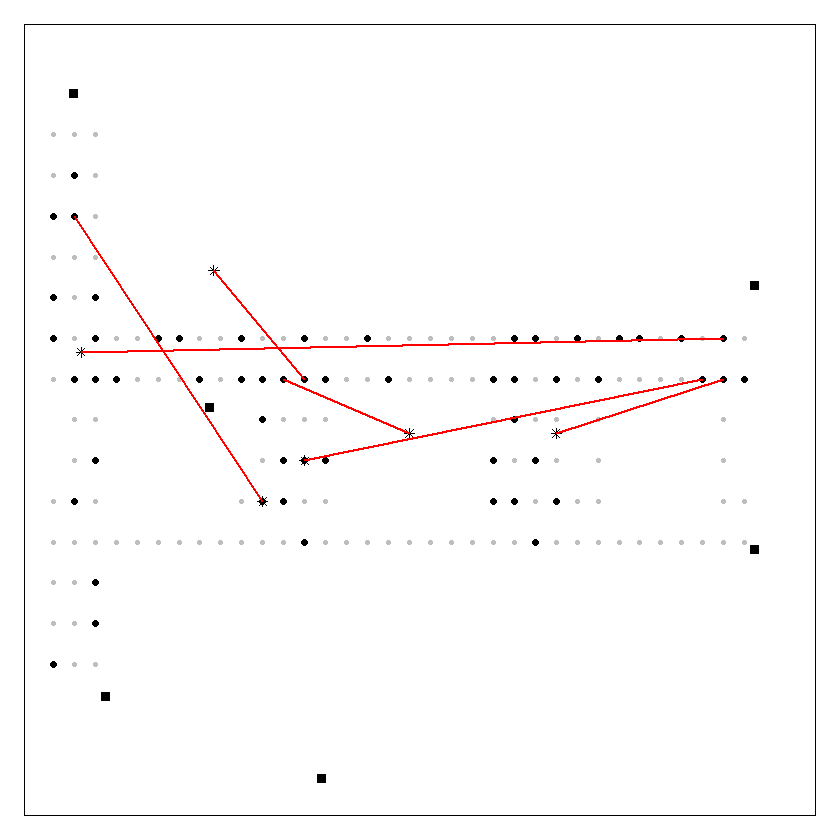

In [122]:
#pdf(file="GEO_FloorPlanK3Errors.pdf", width = 10, height = 7)
oldPar = par(mar = c(1, 1, 1, 1))
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)
par(oldPar)
dev.off()

# #pdf(file="GEO_FloorPlanK1Errors.pdf", width = 10, height = 7)
# oldPar = par(mar = c(1, 1, 1, 1))
# floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
#               trainPoints = trainPoints, AP = AP)
# par(oldPar)
# dev.off()

In [123]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

In [124]:
actualXY = onlineSummary[ , c("posX", "posY")]
# sapply(list(estXYk1, estXYk3), calcError, actualXY)

head(actualXY)

,posX,posY
0-0,0,0
0-11,0,11
0-8,0,8
0-9,0,9
1-11,1,11
1-12,1,12


## Cross Validation

In [125]:
v = 11 # Number of folds

permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))

head(permuteLocs)

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
"data length [166] is not a sub-multiple or multiple of the number of rows [15]"

0-4,15-3,5-8,17-8,9-7,1-10,23-8,13-4,19-8,13-5,0-12
17-3,11-6,12-5,21-5,13-8,2-9,22-3,7-8,0-9,27-7,0-10
0-2,22-4,7-7,30-3,12-4,2-6,31-8,2-1,25-3,20-8,22-7
23-3,32-6,26-6,2-11,15-8,6-8,33-8,26-8,11-4,24-4,1-8
3-8,12-8,21-6,1-13,28-8,0-11,4-7,9-4,23-5,29-8,31-7
2-3,14-7,3-7,13-6,3-3,6-7,1-9,16-8,21-8,19-7,26-3


In [143]:
onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])

head(onlineFold)

,time,posX,posY,orientation,mac,signal,posXY,rawTime,angle,medSignal,avgSignal,num,sdSignal,iqrSignal
49625,2006-02-11 02:26:28,0,2,0.3,00:0f:a3:39:e1:c0,-58,0-2,1.139646e+12,0,-60,-59.95455,110,2.662641,4
99008,2006-02-11 03:05:57,0,4,0.5,00:0f:a3:39:e1:c0,-48,0-4,1.139649e+12,0,-47,-48.09091,110,2.676933,5
138863,2006-02-11 03:58:42,1,6,0.6,00:0f:a3:39:e1:c0,-49,1-6,1.139652e+12,0,-47,-46.96364,110,3.359028,1
363611,2006-02-11 08:54:08,10,3,0.4,00:0f:a3:39:e1:c0,-44,10-3,1.139670e+12,0,-44,-45.24545,110,2.696196,4
453660,2006-02-11 11:12:14,10,6,1.0,00:0f:a3:39:e1:c0,-44,10-6,1.139678e+12,0,-43,-42.79091,110,1.084465,1
370959,2006-02-11 09:05:39,11,3,359.9,00:0f:a3:39:e1:c0,-51,11-3,1.139670e+12,0,-51,-50.34545,110,1.222393,1


In [130]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [131]:
offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

head(onlineCVSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,225.6,225,-54.62727,-64.89247,-64.01205,-36.13542,-66.20879,-54.10101
0-1,0-1,0,1,315.3,315,-54.58182,-67.58763,-71.98795,-37.77451,-67.33333,-58.61957
0-10,0-10,0,10,225.3,225,-51.47706,-63.01163,-68.58416,-49.01010,-66.71111,-54.56180
0-11,0-11,0,11,45.3,45,-55.24545,-70.48235,-68.87356,-54.70526,-64.23377,-59.23656
0-12,0-12,0,12,0.2,0,-56.60000,-67.56667,-71.97959,-38.40404,-68.48235,-54.56122
0-13,0-13,0,13,180.3,180,-55.68182,-70.91919,-71.13043,-43.46809,-69.88889,-58.40860


### Calculate error

In [144]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] NA

In [138]:
head(onlineCVSummary)

,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0,0-0,0,0,225.6,225,-54.62727,-64.89247,-64.01205,-36.13542,-66.20879,-54.10101
0-1,0-1,0,1,315.3,315,-54.58182,-67.58763,-71.98795,-37.77451,-67.33333,-58.61957
0-10,0-10,0,10,225.3,225,-51.47706,-63.01163,-68.58416,-49.01010,-66.71111,-54.56180
0-11,0-11,0,11,45.3,45,-55.24545,-70.48235,-68.87356,-54.70526,-64.23377,-59.23656
0-12,0-12,0,12,0.2,0,-56.60000,-67.56667,-71.97959,-38.40404,-68.48235,-54.56122
0-13,0-13,0,13,180.3,180,-55.68182,-70.91919,-71.13043,-43.46809,-69.88889,-58.40860


### Calculate true error after cross validation

In [145]:
K = 5 #20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

print(err) # error for each fold

[1] NA NA NA NA NA


### Select Number of cross validation folds

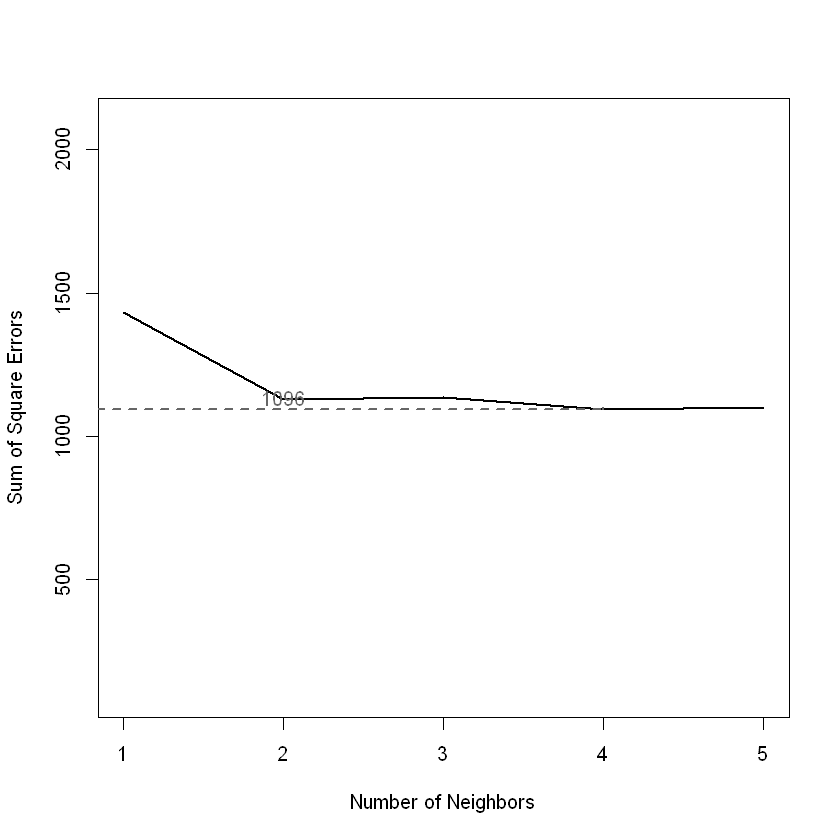

In [105]:
#pdf(file = "Geo_CVChoiceOfK.pdf", width = 10, height = 6)
#oldPar = par(mar = c(4, 3, 1, 1))
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(100, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))
# par(oldPar)
# dev.off()